In [1]:
# This notebook generates the results in appendix E.
# It shows how to compute bootstrap confidence intervals for CE and CalLoss for one of the systems.
# Note that here we assume that samples are iid. If this is not the case, the bootstrap samples 
# should be created by sampling by whatever condition introduces the correlations. For example, in a dataset
# composed by many samples from each of N different speakers, the bootstrap samples would need to be
# created by speaker. The method create_bootstrap_set has an optional argument called condition
# which can be used to pass the correlation-inducing condition of each sample.


import matplotlib.pyplot as plt
import numpy as np
from expected_cost import ec, utils
from expected_cost.data import create_scores_for_expts
from expected_cost.calibration import calibration_with_crossval, calibration_train_on_test
from expected_cost.psrcal_wrappers import Brier, LogLoss, CalLoss
from psrcal.calibration import HistogramBinningCal

outdir = "outputs/"
utils.mkdir_p(outdir)

# Method to obtain the 95% confidence interval    
def get_conf_int(vals, alpha=5):
    return (np.percentile(vals, alpha/2), np.percentile(vals, 100-alpha/2))

In [2]:
# Create the data

num_targets = 2
N = 200 * num_targets
feat_var = 0.15
score_dict, targets = create_scores_for_expts(num_targets, N=N, P0=0.8, simple_names=True, feat_var=feat_var, sim_name='gaussian_sim_md')

print(Brier(score_dict['cal'], targets))


0.3683633176519441


In [3]:
# Compute the metrics for many bootstrap samples for each of the scores considered in the paper.
# Note that this might take a while. You can speed up the process by reducing numbootstraps.

metric = Brier # LogLoss or Brier
metric_name = 'BS'

numbootstraps = 100
score_names = ['cal', 'mcp', 'mcs', 'mcps']
nbins = 15

epsr_vals = {}
calloss_vals = {} 
scores_cal = {}

for j, score_name in enumerate(score_names):

    scores = score_dict[score_name]
    epsr_vals[score_name] = []
    calloss_vals[score_name] = {'Axv': [], 'Att': [], 'Htt': [], 'Hxv': []}

    for nb in np.arange(numbootstraps):

        # Scores, targets and conditions for the bootstrap set. The cond_bt variable contains the
        # selected indices if the input conditions are None, or the conditions of the selected samples
        # if conditions are provided as input.
        if nb==0:
            # For the first nb, just keep the whole test data (this is to avoid repeating all the code
            # below for that data outside the loop)
            scores_bt, targets_bt, cond_bt = scores, targets, None
        else:              
            scores_bt, targets_bt, cond_bt = utils.create_bootstrap_set(scores, targets, conditions=None)

        # Use cond_bt to determine the folds. This is important even if conditions is None because
        # otherwise the same exact sample may appear across more than one fold which would defeat the
        # purpose of doing xval.
        scores_cal['Axv'] = calibration_with_crossval(scores_bt, targets_bt, condition_ids=cond_bt)
        scores_cal['Att'] = calibration_train_on_test(scores_bt, targets_bt)
        
        # You can check that increasing M results in more and more overfitting of the calibration
        # transform which in turn results in an overestimation of the calibration loss.
        scores_cal['Hxv'] = calibration_with_crossval(scores_bt, targets_bt, calmethod=HistogramBinningCal, calparams={'M':nbins}, condition_ids=cond_bt)
        scores_cal['Htt'] = calibration_train_on_test(scores_bt, targets_bt, calmethod=HistogramBinningCal, calparams={'M':nbins})

        # The array below can be used to get a confidence interval on the epsr itself
        epsr_vals[score_name].append(metric(scores_bt, targets_bt))
        
        for caltype in scores_cal.keys():
            calloss_vals[score_name][caltype].append(CalLoss(metric, scores_bt, scores_cal[caltype], targets_bt))
    

    


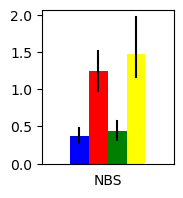

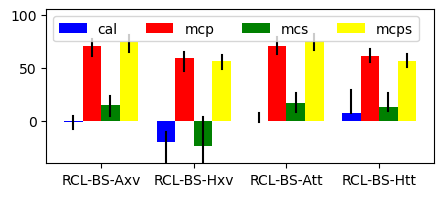

In [4]:
# set width of bar
barWidth = 0.2
color = ['blue', 'red', 'green', 'yellow']
caltypes = ['Axv', 'Hxv', 'Att', 'Htt']
alpha = 5

fig, ax = plt.subplots(figsize=(1.7,2))
for j, score_name in enumerate(score_names):
    
    vals = epsr_vals[score_name]
    
    # Take the first value in the list, which was computed using the whole test set without sampling
    # as the bar height (for consistency with results in the main body of the paper)
    ax.bar(barWidth*j, vals[0], color=color[j], width = barWidth, label=score_name)
    # One could, instead plot the bar height as the mean over all bootstrap samples
    #ax.bar(barWidth*j, np.mean(vals[1:]), color=color[j], width = barWidth, label=score_name)

    # Compute the confidence intervals using all elements in the list from the second to the last
    ax.plot(barWidth*j*np.ones(2),get_conf_int(vals[1:], alpha=alpha), 'k')
    
ax.set_xlabel('N%s'%metric_name)
ax.set_xticks([])
ax.set_xlim([-2*barWidth,5*barWidth])

plt.savefig(f"{outdir}/confidence_intervals_epsr.pdf")

# Next, repeat the plot for three RCL metrics computed with different calibration approaches

fig, ax = plt.subplots(figsize=(5,2))
for j, score_name in enumerate(score_names):

    vals = calloss_vals[score_name]
    xvalues = np.arange(len(vals)) + barWidth * j
    yvalues = [vals[caltype][0] for caltype in caltypes]

    ax.bar(xvalues, yvalues, color=color[j], width = barWidth, label=score_name)
    for k, caltype in enumerate(caltypes):
        ax.plot(xvalues[k]*np.ones(2),get_conf_int(vals[caltype], alpha=alpha), 'k')

ax.set_xticks(np.arange(len(caltypes)) + barWidth * 1.5, ['RCL-%s-%s'%(metric_name,c) for c in caltypes])
ax.legend(loc='upper left', ncol=4)

ax.set_ylim([-40,105])

plt.savefig(f"{outdir}/confidence_intervals_calloss.pdf")

